<a href="https://colab.research.google.com/github/mddsayemm/Precision-Farming/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
data_dir = '/content/drive/MyDrive/dataset/SugarWeed'

In [ ]:
# Load datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data transformations
data_transforms = {
'train': transforms.Compose([
transforms.Resize((224, 224)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224,
0.225])
]),
'val': transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224,
0.225])
]),
}
# Load datasets
data_dir = '/content/drive/MyDrive/dataset/SugarWeed'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}",
transform=data_transforms[x])
for x in ['train', 'val']}
dataloaders = {
'train': DataLoader(image_datasets['train'], batch_size=32,
shuffle=True, num_workers=2),
'val': DataLoader(image_datasets['val'], batch_size=32,
shuffle=False, num_workers=2)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)


{'train': 3682, 'val': 1578}


Epoch 1/2
----------
train Loss: 0.0908 Acc: 0.9739
val Loss: 0.0454 Acc: 0.9823

Epoch 2/2
----------
train Loss: 0.0232 Acc: 0.9940
val Loss: 0.0345 Acc: 0.9854

Best val Acc: 0.9854
Model training complete and saved.


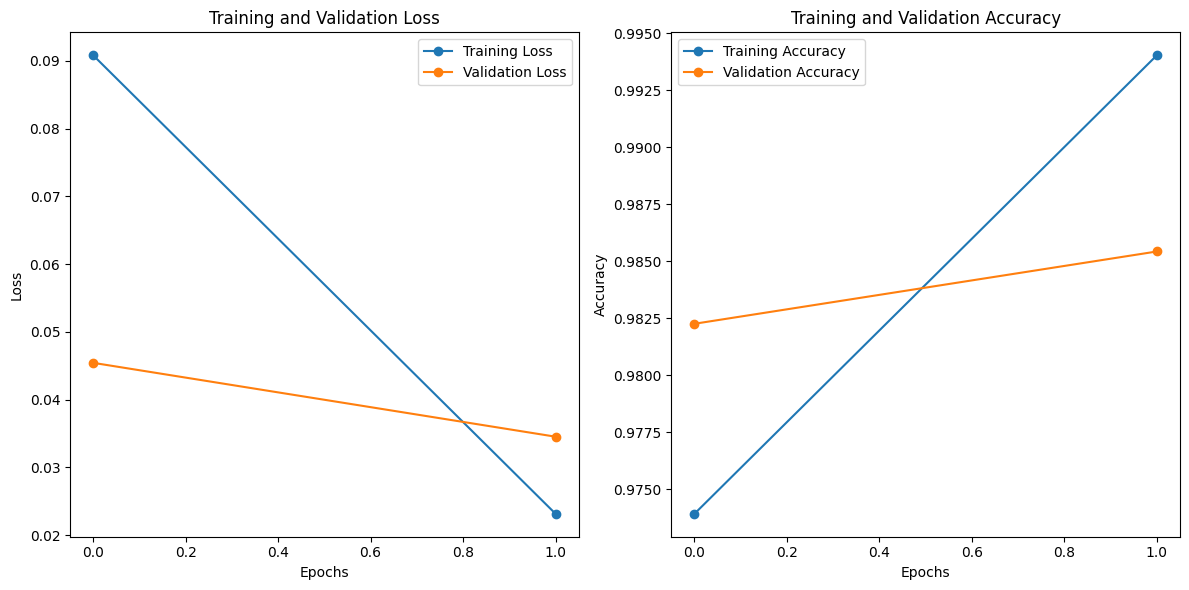

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming class_names, dataloaders, and dataset_sizes are already defined
class_names = ['class1', 'class2']  # Replace with your actual class names
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet model and modify for your dataset
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the training function with metric tracking
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=2):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Metric tracking
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Track metrics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and metrics
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model with 2 epochs
trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=2
)

# Save the trained model
torch.save(trained_model.state_dict(), "sugarweed_model.pth")
print("Model training complete and saved.")

# Plot the metrics
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-16-2c2262acf3df>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sugarweed_model.pth", map_location=device))  # Load saved

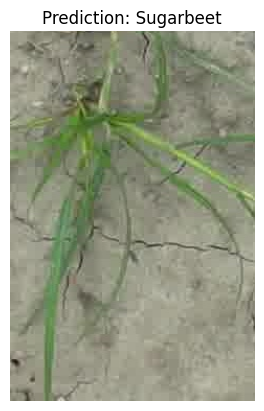

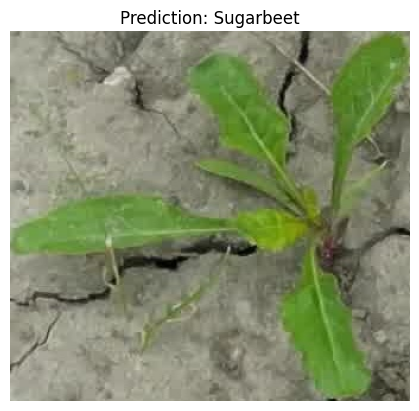

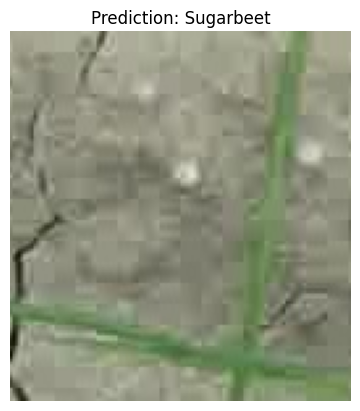

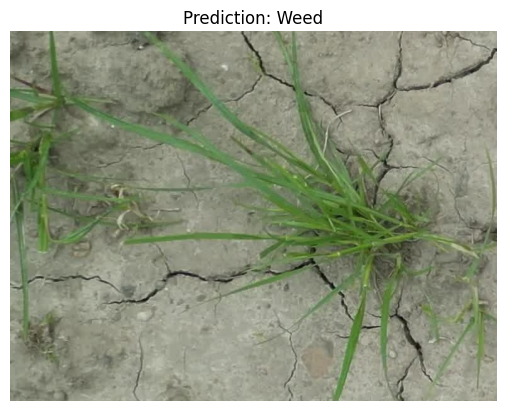

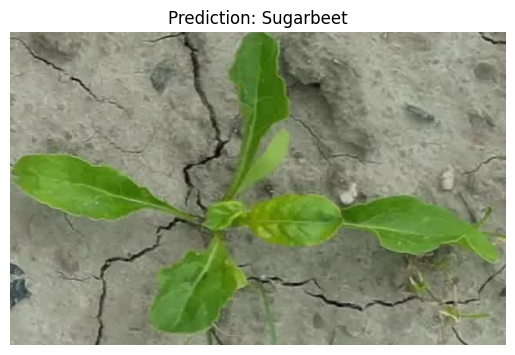

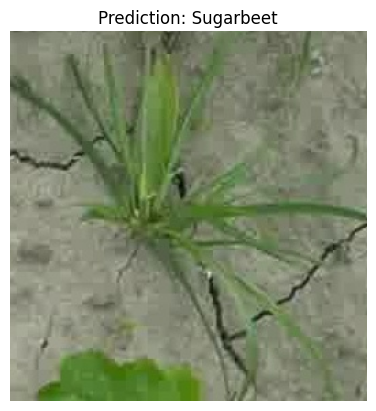

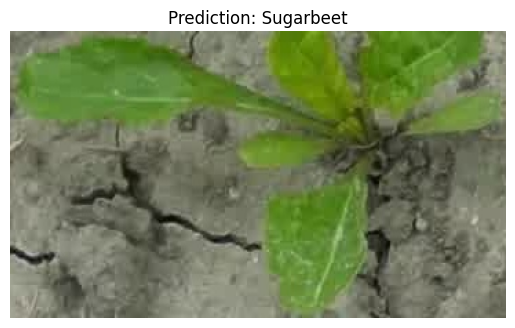

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

# Define the test folder path
test_folder = "/content/test"

# Define the class names
class_names = ['Sugarbeet', 'Weed']  # Replace with the actual class names if different

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the same transforms as used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to match ResNet input size
    transforms.ToTensor(),         # Convert image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the trained model
model = models.resnet18(pretrained=False)  # Pretrained=False because we're loading custom weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Modify for your number of classes
model.load_state_dict(torch.load("sugarweed_model.pth", map_location=device))  # Load saved model
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to predict and display results
def predict_and_visualize(test_folder, model, transform):
    # Get a list of all files in the test folder
    test_images = os.listdir(test_folder)

    # Iterate through each image
    for img_name in test_images:
        img_path = os.path.join(test_folder, img_name)

        # Open and preprocess the image
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Model prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)  # Get the class index with the highest score
            label = class_names[predicted.item()]  # Map index to class name

        # Display the image and prediction
        plt.imshow(image)
        plt.title(f"Prediction: {label}")
        plt.axis('off')
        plt.show()

# Run the prediction and visualization
predict_and_visualize(test_folder, model, transform)
